<ul><li>American Gut Project
</li><li>License: BSD
</li><li>Author of this notebook: Jamie Morton
</li><li>Last Update: March 2014
</li></ul>

The following libraries will need to be installed
</li><li><a href="https://www.python.org/download/releases/2.7/">Python 2.7</a>
</li><li><a href="http://pycogent.org/">Pycogent 1.5.3</a>
</li><li><a href="http://picrust.github.io/picrust/install.html#install">PiCRUST</a>
</li><li><a href="http://biom-format.org/index.html">BIOM 1.3.1</a>
</li><li><a href="http://www.numpy.org/">Numpy 1.5.1</a>
</li><li><a href="http://www.scipy.org">SciPy</a>
</li><li><a href="http://pandas.pydata.org">pandas</a>
</li><li><a href="http://statsmodels.sourceforge.net/">statsmodels</a>
</li><li><a href="https://www.gnu.org/software/tar/">The tar utility</a>
</li></ul>

It is suggested to install these packages via pip and virtualenv (with the exception of python and picrust)

In [4]:
import biom
from biom.parse import parse_biom_table
import numpy as np
import pandas as pd
import os, site
from scipy.stats.mstats import kruskalwallis
from statsmodels.sandbox.stats.multicomp import multipletests
base_path = os.path.dirname(os.path.dirname(os.getcwd()))
for directory_name in os.listdir(base_path):
    site.addsitedir(os.path.join(base_path, directory_name))
from time import strftime, strptime
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
print os.getcwd()

/Users/mortonyt/Documents/CUBio/AmericanGut/American-Gut/ipynb


In [6]:
!tar -zxvf ../data/AG/AG_100nt.zip -O > ../data/AG/AG_100nt.json

x AG_100nt.json


We're assuming that all of your data is stored under the `data` folder and your biom file is AGP_100nt_fecal.biom and your metadata file is AGP_100nt_fecal.txt

Lets first calculate copy numbers and predict metagenomes.  We do not want to rarefy because we are interested in the proportions

In [7]:
raw_file = "../data/AG/AG_100nt.json"
norm_file = "picrust/AG_100nt_norm.biom"
metagenomes_file = "picrust/AG_100nt_metagenomes.biom"

In [8]:
!mkdir picrust
!normalize_by_copy_number.py -i $raw_file -o $norm_file
!predict_metagenomes.py -i $norm_file -o $metagenomes_file

mkdir: picrust: File exists


In [21]:
biom_table = parse_biom_table(open(metagenomes_file))

In [29]:
metadata = pd.read_table("../data/AG/AG_100nt.txt", index_col=0, low_memory=False, na_values=['no_data', 'unknown'])

Now, lets convert all of our data into a pandas dataframe

In [30]:
df = pd.DataFrame()
for samp_v, samp_id, samp_md in biom_table.iterSamples():
    df[samp_id] = pd.Series(samp_v, index = biom_table.ObservationIds)
df = df.transpose()

Let's first filter out some of the rare observed genes

In [31]:
# Filter out KOs with less than 1000 estimated genes
table = df.loc[:, df.sum(axis=0) > 1000]

Now let's only consider the heathly subset - using same functionality in Alpha Diversity notebooks.

In [32]:
# Defines the filtering functions for alpha diversity
subset_f = {'AGE': lambda x: 19 < x and not np.isnan(x),          
            'DIABETES': lambda x: x == 'I do not have diabetes',
            'IBD': lambda x: x == 'I do not have IBD',
            'ANTIBIOTIC_SELECT': lambda x: x == 'Not in the last year',
            'BMI': lambda x: 18.5 <= x < 30 and not np.isnan(x)}

# Determines which samples meet the requirements of the categories
new_bin = {}
for cat, f in subset_f.iteritems():
    new_bin[cat] = metadata[cat].apply(f)

# Builds up the new binary dataframe
bin_frame = pd.DataFrame(new_bin)

# Adds a column to the current dataframe to look at the subset
bin_series = pd.DataFrame(new_bin).all(1)

# Filters the original mapping file so only samples which satisfy the criteria are included in the new metadata file.
metadata = metadata.groupby(bin_series).get_group(True)

And trim out all samples in table not in metadata and normalize the data so that all of the OTU abundances for each sample adds up to 1.

In [33]:
table = table.loc[metadata.index]
table = table.div(table.sum(axis=1), axis=0)

In [34]:
def kw_test(table, metadata, cat):
    group_indeces = metadata.groupby(cat).groups.values()
    f = lambda x: kruskalwallis(*[x.loc[i] for i in group_indeces])
    results = table.apply(f, axis=0)
    # Don't forget about multiple comparison testing
    reject, pvalues, _, _ = multipletests(zip(*results.values)[1])
    keggs = zip(table.columns, pvalues, reject)
    accepted_keggs=filter(lambda x: x[2]==True, keggs)
    accepted_keggs=sorted(accepted_keggs, key=lambda x: x[1])
    return accepted_keggs

Now, apply Krustal-Wallis to test for group signficances between types of plants consumed

In [35]:
accepted_plant_keggs = kw_test(table, metadata, "TYPES_OF_PLANTS")
accepted_plant_keggs

[(u'K03483', 0.043919213648777156, True)]

In [36]:
def reorder_dataframe(order, metadata, keggs, cat, order_name):
    order = np.array(order)
    df = pd.DataFrame()
    df[keggs] = table[keggs]
    df[cat] = metadata[cat]
    df = df[pd.notnull(metadata[cat])]
    df[order_name] = map(lambda x: int(np.where(order==x)[0]), df[cat])
    df = df.sort(order_name)
    return df

In [37]:
num_plant_types = ['Less than 5', '6 to 10', '11 to 20', '21 to 30', 'More than 30', np.nan]
plant_kegg = accepted_plant_keggs[0][0]
plant_df = reorder_dataframe(order=num_plant_types, 
                             metadata=metadata, 
                             keggs=plant_kegg, 
                             cat="TYPES_OF_PLANTS", order_name="PLANT_ORDER")

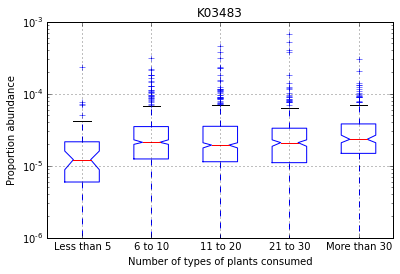

In [38]:
fig1 = plant_df.boxplot(column=plant_kegg,
                        by='PLANT_ORDER', notch=True, bootstrap=10000)
plt.title(plant_kegg)
plt.suptitle("")
plt.xticks(np.arange(5)+1, num_plant_types)
plt.xlabel('Number of types of plants consumed')
plt.ylabel('Proportion abundance')
plt.yscale('log')

Apparently, [K03483](http://www.genome.jp/dbget-bin/www_bget?ko:K03483) is a transcriptional antiterminator, which fixes pretermination of RNA transcription.

Now, let's investigate how predicted gene abundances vary with collection month.  First, let's bin the ages into decades, before running the krustal wallis test

In [39]:
# Sets up the category parameters
category = 'COLLECTION_MONTH'
base_cat = 'COLLECTION_DATE'

# Sets a function to convert the collection date, if necessary
def get_month(date_str):
    """converts a date to a month string"""
    if len(date_str) > 8:
        return strftime('%B', strptime(date_str, '%m/%d/%Y'))
    else:
        return strftime('%B', strptime(date_str, '%m/%d/%y'))
# Converts the collection date
if category not in metadata.columns:
    metadata[category]= metadata[base_cat].apply(get_month)

In [40]:
accepted_month_keggs = kw_test(table, metadata, "COLLECTION_MONTH")
accepted_month_keggs

[(u'K05844', 0.0, True),
 (u'K00508', 0.0, True),
 (u'K05596', 0.0, True),
 (u'K01828', 0.0, True),
 (u'K03647', 0.0, True),
 (u'K12428', 0.0, True),
 (u'K08994', 0.0, True),
 (u'K02475', 0.0, True),
 (u'K02476', 0.0, True),
 (u'K09019', 0.0, True),
 (u'K13927', 0.0, True),
 (u'K00758', 0.0, True),
 (u'K07156', 0.0, True),
 (u'K05365', 0.0, True),
 (u'K06945', 0.0, True),
 (u'K10805', 0.0, True),
 (u'K05564', 0.0, True),
 (u'K05560', 0.0, True),
 (u'K04766', 0.0, True),
 (u'K04768', 0.0, True),
 (u'K09681', 0.0, True),
 (u'K00301', 0.0, True),
 (u'K13693', 0.0, True),
 (u'K05977', 0.0, True),
 (u'K07110', 0.0, True),
 (u'K07113', 0.0, True),
 (u'K07119', 0.0, True),
 (u'K03919', 0.0, True),
 (u'K02351', 0.0, True),
 (u'K13573', 0.0, True),
 (u'K13572', 0.0, True),
 (u'K10843', 0.0, True),
 (u'K01720', 0.0, True),
 (u'K03761', 0.0, True),
 (u'K12583', 0.0, True),
 (u'K07465', 0.0, True),
 (u'K10674', 0.0, True),
 (u'K10240', 0.0, True),
 (u'K10241', 0.0, True),
 (u'K02616', 0.0, True),


In [41]:
## Reorder the labels
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 
               'December']
month_kegg = accepted_month_keggs[0][0]
month_df = reorder_dataframe(order=month_names, 
                             metadata=metadata, 
                             keggs=month_kegg, 
                             cat="COLLECTION_MONTH", order_name="MONTH_ORDER")

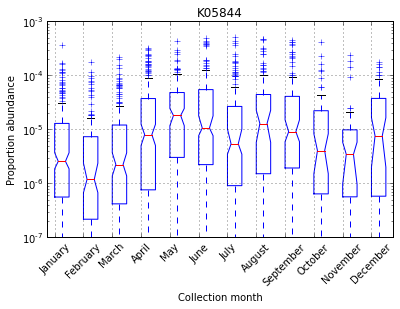

In [42]:
fig1 = month_df.boxplot(column=month_kegg, by='MONTH_ORDER', notch=True,bootstrap=10000)
plt.title(accepted_month_keggs[0][0])
plt.suptitle("")
plt.xticks(np.arange(12)+0.75, month_names, rotation=45)
plt.xlabel('Collection month')
plt.ylabel('Proportion abundance')
plt.yscale('log')

[K05844](http://www.genome.jp/dbget-bin/www_bget?ko:K05844) is suspected to encode for a ribosomal protein. rimK has been found to be a modification protein  for the S6 ribosomal protein in E. Coli.

[K09703](http://www.genome.jp/dbget-bin/www_bget?ko:K09703) is a hypothetical protein - so we don't really know what exactly this protein does

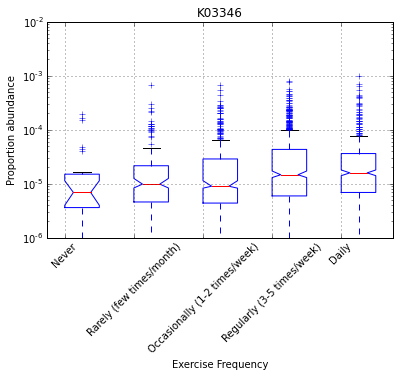

In [233]:
fig1 = exercise_df.boxplot(column=exercise_kegg, by='EXERCISE_ORDER', notch=True,bootstrap=10000)
plt.title(exercise_kegg)
plt.suptitle("")
plt.xticks(np.arange(5)+0.75, exercise_types, rotation=45)
plt.xlabel('Exercise Frequency')
plt.ylabel('Proportion abundance')
plt.yscale('log')

[K03346](http://www.genome.jp/dbget-bin/www_bget?ko:K03346) is known to be critical for DNA initiation and replication.  

In [ ]:
accepted_sleep_keggs = kw_test(table, metadata, "SLEEP_DURATION")
accepted_sleep_keggs

In [ ]:
sleep_types = ['Less than 5 hours',
               '5-6 hours',
               '6-7 hours',
               '7-8 hours',
               '8 or more hours']
sleep_kegg = accepted_sleep_keggs[0][0]
sleep_df = reorder_dataframe(order=sleep_types, 
                             metadata=metadata, 
                             keggs=sleep_kegg, 
                             cat='SLEEP_DURATION', order_name="SLEEP_ORDER")

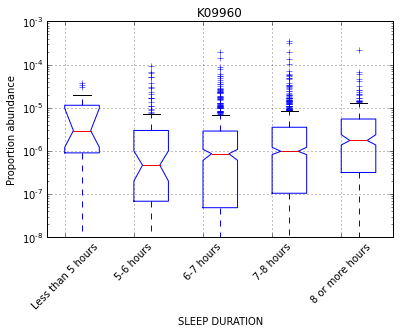

In [240]:
fig1 = sleep_df.boxplot(column=sleep_kegg, by='SLEEP_ORDER', notch=True,bootstrap=10000)
plt.title(sleep_kegg)
plt.suptitle("")
plt.xticks(np.arange(5)+0.75, sleep_types, rotation=45)
plt.xlabel('SLEEP DURATION')
plt.ylabel('Proportion abundance')
plt.yscale('log')

[K09960](http://www.genome.jp/dbget-bin/www_bget?ko:K09960) is a hypothetical protein

# Rural Analysis

Let's apply the same analysis to differientiate between Rural and Urban samples.
We'll need to touch up on the metadata and estimate rurality for each of the zip codes first.

In [279]:
metadata = metadata.loc[metadata["COUNTRY"] =="GAZ:United States of America",:]

metadata["ZIP"] = map(str, metadata["ZIP"])
metadata["ZIP"] = map(lambda x: x if(x!='nan') else None,metadata["ZIP"])
metadata["ZIP"] = map(lambda x: x.split('-')[0] if x!=None else x, metadata["ZIP"])

zip_fp = "%s/../data/AG/zip_rural.csv"%(os.getcwd())
zip_map = pd.read_csv(zip_fp)
zip_map=zip_map.rename(columns={'zip':'ZIP'})
zip_map["Rural"] = zip_map["ru2003"]>=6
zip_map["ZIP"] = map(str,zip_map["ZIP"])

metadata['SampleID'] = metadata.index
metadata = pd.merge(metadata,zip_map,how='inner',on="ZIP")
metadata.index = metadata['SampleID']
metadata = metadata.sort()

Index([u'000001011.1210950', u'000001020.1262078', u'000001030.1257529', u'000001030.1261848', u'000001062.1131940', u'000001069.1130076', u'000001072.1076364', u'000001089.1075745', u'000001097.1075899', u'000001098.1076016', u'000001099.1076045', u'000001100.1075827', u'000001111.1076323', u'000001115.1076083', u'000001116.1075711', u'000001127.1131821', u'000001141.1075936', u'000001142.1075871', u'000001150.1076054', u'000001151.1075997', u'000001152.1075756', u'000001155.1075796', u'000001170.1075761', u'000001171.1076095', u'000001174.1076024', u'000001175.1257200', u'000001184.1131760', u'000001187.1262006', u'000001194.1075909', u'000001196.1076040', u'000001203.1076359', u'000001209.1076406', u'000001218.1075754', u'000001221.1075847', u'000001234', u'000001238.1076317', u'000001240.1053777', u'000001243.1053840', u'000001248.1075959', u'000001252.1076247', u'000001253.1076218', u'000001255.1076444', u'000001263.1076271', u'000001284.1075931', u'000001285.1075917', u'000001286

In [281]:
table = table.loc[metadata.index]
table.shape

(1615, 6207)